In [182]:
%load_ext autoreload 

from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from easydict import EasyDict as edict
import yaml
import pandas as pd
import os

from scipy.signal import convolve2d, convolve
from scipy.signal.windows import blackman, gaussian
import copy
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.metrics import r2_score, make_scorer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_swiss_roll,\
                             make_s_curve,\
                             make_moons

from collections import defaultdict
from joblib import Parallel, delayed
from umap import UMAP

from IPython.core.debugger import set_trace
from IPython.display import clear_output

import torch
from torch import nn
from torch import optim
from torch import autograd

from train_utils import get_capacity, plot_weights_hist, train
from metric_utils import calculate_Q_metrics, \
                         strain, \
                         l2_loss, \
                         r2_score_torch, \
                         to_numpy, \
                         get_pred_index, \
                         numpy_metric, \
                         cosine_sim

from input_utils import create_data


plt.rcParams['font.size'] = 20
device = torch.device('cuda:0')
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
SCALER = StandardScaler() 
input_parameters = {'generator': make_blobs, #make_s_curve, 
                    'generator_kwargs': {'n_samples':1000, 
                                         'cluster_std':1}, 
                    'normalize':True,
                    'unsupervised':False,
                    'normalize_output':False,
                    'scaler':SCALER,
                    'whiten':False
                   }

inpt, outpt = create_data(**input_parameters)
inpt_test, outpt_test = create_data(**input_parameters)

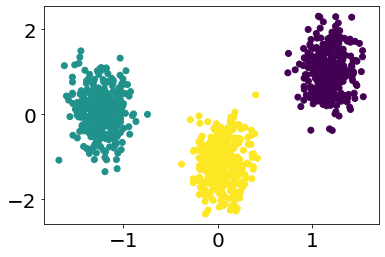

In [100]:
plt.scatter(inpt[0], inpt[1], c=outpt[0])

In [101]:
pf_gen = PolynomialFeatures(degree=3, include_bias=False)
inpt_poly = pf_gen.fit_transform(inpt.T).T
W = np.random.randn(3,9)
W /= np.linalg.norm(W, axis=1, keepdims=True)
# Z = np.tanh(W@inpt_poly)
Z = W@inpt_poly

Z = SCALER.fit_transform(Z.T).T

In [102]:
plt.ioff()
plt.figure()
df = pd.DataFrame(Z.T, columns=['x','y','z'])
df['target'] = outpt[0]
fig = px.scatter_3d(df, x='x', y='y', z='z', color='target')

fig.show()

<Figure size 432x288 with 0 Axes>

In [104]:
umap = UMAP(n_components=2)
X_pred = umap.fit_transform(Z.T)

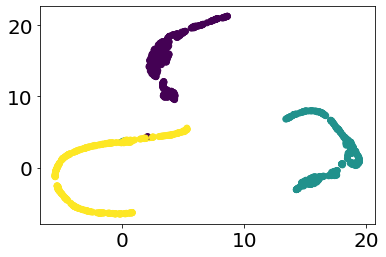

In [106]:
plt.scatter(X_pred[:,0], X_pred[:,1], c=outpt[0])

# TSNE-net

In [114]:
X,y = make_swiss_roll(n_samples=1000)
X_tensor = torch.tensor(X).to(device)

In [174]:
sum_X = np.sum(np.square(X), axis=1)

In [176]:
(sum_X + sum_X[:,None])

(1000, 1000)

In [180]:
P = compute_joint_probabilities(X, verbose=0)

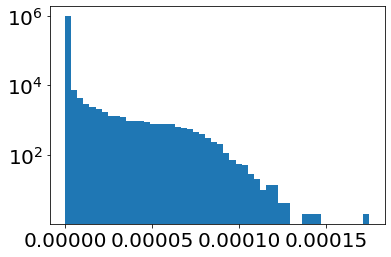

In [181]:
plt.hist(P.flatten(), bins=50)
plt.yscale('log')
plt.show()

In [137]:
n = X.shape[0]
batch_size = 100
batch_size = min(batch_size, n)
batch_count = int(n / batch_size)

In [138]:
model = torch.nn.Sequential(
    torch.nn.Linear(3, 10), torch.nn.Tanh(),
    torch.nn.Linear(10, 10), torch.nn.Tanh(),
    torch.nn.Linear(10, 2)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

In [139]:
losses = []

for epoch in tqdm(range(100)):      
    adjust_learning_rate(optimizer, epoch)

    x_var = autograd.Variable(torch.Tensor(X), requires_grad=False).to(device)
    P_var = autograd.Variable(torch.Tensor(P), requires_grad=False).to(device)

    y_pred = model(x_var)
    
    loss = tsne_loss(P_var, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 251.22it/s]


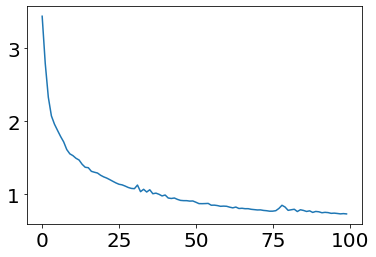

In [142]:
plt.plot(losses)

In [147]:
Z = to_numpy(y_pred.T)

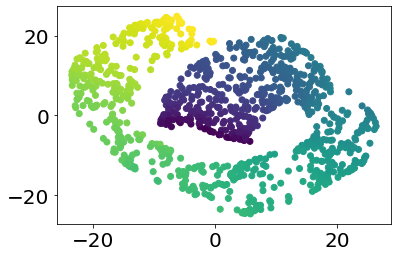

In [153]:
plt.scatter(Z[0], Z[1], c=y)